# STANDALONE STUDY
## **SPATIAL FOURBAR**
-----------------

## Environment Setup
--------------------

### Colab Session
*Run if in a Colab Session Only!*

#### Setting-up Colab Virtual Machine
This will clone the package repository and install the needed modules into the Virtual Machine dedicated for the running notebook session.

In [ ]:
!git clone https://github.com/khaledghobashy/smbd.git
!cd smbd/smbd/numenv/python/numerics/core/math_funcs/_cython_definitions && python setup.py build_ext -if
!pip install sympy==1.4

Adding package path to the python system path and creating a new folder, **smbd_project**, where we can store the model files and results.

In [ ]:
import os
import sys

pkg_path = '/content/smbd'
sys.path.append(pkg_path)

os.mkdir('smbd_project')
os.chdir('smbd_project')

#### Rendering SymPy in Colab
Rendering SymPy equations in Colab requires the MathJax javascript library to be available within each cell output. The following defines an execution hook that loads it automatically each time you execute a cell.

In [ ]:
from IPython.display import Math, HTML

def load_mathjax_in_cell_output():
  display(HTML("<script src='https://www.gstatic.com/external_hosted/"
               "mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register('pre_run_cell', load_mathjax_in_cell_output)

---------------------------------------------------------------

### Local Session
*Run if on your Local Machine!*</br>

The ```pkg_path``` variable is where you have the repository on your machine and should be changed to where you cloned the repository.</br>
*Uncomment the code below and change the ```pkg_path``` variable!*

In [1]:
#import sys
#pkg_path = '/path/to/smbd'
#sys.path.append(pkg_path)

---------------------------------------------------------------
---------------------------------------------------------------

Creating Project Directory

In [1]:
from uraeus.smbd.systems import standalone_project

In [2]:
project = standalone_project()
project.create()

---------------------------------------------------------------
---------------------------------------------------------------

## **SYSTEM DESCRIPTION**
-------------------------

In [65]:
from IPython.display import display, Markdown
display(Markdown(filename='spatial_fourbar.md'))

# SPATIAL FOURBAR
**STANDALONE TOPOLOGY**

------------------------------------------

### **Summary**
A four-bar linkage is the simplest movable closed chain linkage. It consists of four bodies, called bars or links, connected in a loop by four joints that gives the mechanism only 1 degree-of-freedom. More general information can be found on [wikipedia](https://en.wikipedia.org/wiki/Four-bar_linkage).

------------------------------------------

### **Topology Layout**
The mechanism consists of 3 Bodies + 1 Ground. Therefore, total system coordinates -including the ground- is 
$$n=n_b\times7 = 4\times7 = 28$$ 

where $n_b$ is the total number of bodies.  [^1]

The list of bodies is given below:

- Crank $l_1$.
- Connecting-Rod $l_2$.
- Rocker $l_3$.

The system connectivity is as follows:
- Crank $l_1$ is connected to the ground by a revolute joint, resulting in constraint equations $n_{c,rev} = 5$
- Connecting-Rod $l_2$ is connected to the Crank $l_1$ by a spherical joint, resulting in constraint equations $n_{c,sph} = 3$
- Rocker $l_3$ is connected to Connecting-Rod $l_2$ by a universal joint, resulting in constraint equations $n_{c,uni} = 4$
- Rocker $l_3$ is connected to the ground by a revolute joint, resulting in constraint equations $n_{c,tri} = 5$
- Total free DOF is $$n-( n_{c,rev}+n_{c,sph}+n_{c,uni}+n_{c,P}+n_{c,g}) = 28-(10+3+4+(3\times1)+7) = 28-27 = 1$$, where the $n_{c,P}$ and $n_{c,g}$ represents the constraints due to euler-parameters normalization equations and the ground-constraints respectively.
- The Crank revolute joint is actuated by a rotational actuator, resulting in constraint equations $n_{c,act} = 1$



| Joint Name  | Body i         | Body j         | Joint Type | $n_c$ |
|:-----------:|:-------------- |:-------------- | ---------- | ----- |
| a           | Ground         | Crank          | Revolute   | 5     |
| b           | Crank          | Connecting-Rod | Spherical  | 3     |
| c           | Connecting-Rod | Rocker         | Universal  | 4     |
| d           | Rocker         | Ground         | Revolute   | 5     |

-------------------------------------------------------



[^1]: The tool uses [euler-parameters](https://en.wikibooks.org/wiki/Multibody_Mechanics/Euler_Parameters) -which is a 4D unit quaternion- to represents bodies orientation in space. This makes the generalized coordinates used to fully define a body in space to be **7,** instead of **6**, it also adds an algebraic equation to the constraints that ensures the unity/normalization of the body quaternion. This is an important remark as the calculations of the degrees-of-freedom depends on it.



---------------------------------------------------------------
---------------------------------------------------------------

## **SYMBOLIC TOPOLOGY**
------------------------

In this section, we create the symbolic topology that captures the topological layout that we just discussed.</br>
Defining the topology is very simple. We start by importing the ```standalone_topology``` class and create a new instance that represents our symbolic model. Then we start adding the components we discussed earlier, starting by the bodies, then the joints, actuators and forces, and thats it.</br>
These components will be represented symbolically, and therefore there is no need for any numerical inputs at this step.

The system is stored in a form of a network graph that stores all the data needed for the assemblage of the system equations later. But even before the assemblage process, we can gain helpful insights about our system as well be shown.


In [ ]:
from uraeus.smbd.systems import standalone_topology, configuration

In [2]:
project_name = 'spatial_fourbar'

In [3]:
sym_model = standalone_topology(project_name)

### Adding Bodies

In [4]:
sym_model.add_body('l1')
sym_model.add_body('l2')
sym_model.add_body('l3')

### Adding Joints

In [5]:
sym_model.add_joint.revolute('a','ground','rbs_l1')
sym_model.add_joint.spherical('b','rbs_l1','rbs_l2')
sym_model.add_joint.universal('c','rbs_l2','rbs_l3')
sym_model.add_joint.revolute('d','rbs_l3','ground')

### Adding Actuators

In [6]:
sym_model.add_actuator.rotational_actuator('act', 'jcs_a')

### Adding Forces

In [7]:
#model.add_force.internal_force('force_name', 'body_1', 'body_2', mirror=False)

### **SYMBOLIC CHARACTERISTICS**

#### Topology Graph
Visualizing the connectivity of the system as a network graph, where the nodes represent the bodies, and the edges represent the joints, forces and/or actuators between the bodies.

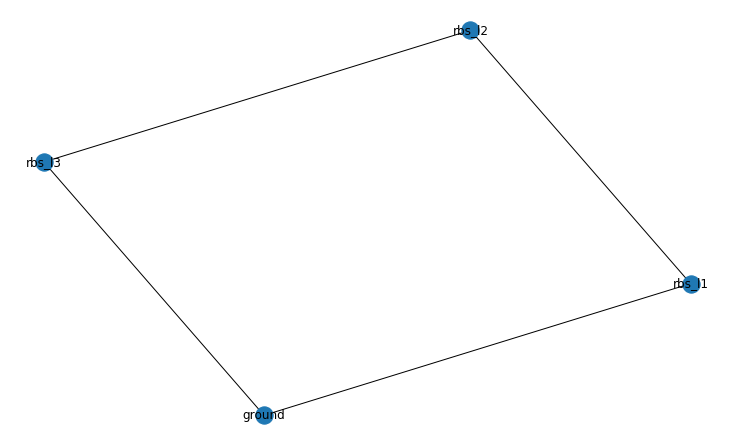

In [8]:
sym_model.topology.draw_constraints_topology()

Checking the system's number of generalized coordinates $n$ and number of constraints $n_c$.

In [9]:
sym_model.topology.n, sym_model.topology.nc 

(28, 28)

### **ASSEMBLING**

This is the last step of the symbolic building process, where we make the system starts the assemblage process of the governing equations, which will be used then in the code generation for the numerical simulation, and also can be used for further symbolic manipulations.</br>

*Note: The equations' notations will be discussed in the tool documentation files.*

In [10]:
sym_model.assemble()

In [11]:
sym_model.save('model_data')

#### Checking the System Equations

In [12]:
sym_model.topology.pos_equations

Matrix([
[                                                                                                             A({P_{ground}})*{\bar{u}^{ground}_{jcs_a}} - A({P_{rbs_l1}})*{\bar{u}^{rbs_l1}_{jcs_a}} + {R_{ground}} - {R_{rbs_l1}}],
[                                                                                                                                       Mbar_ground_jcs_a[:,(0, 1)].T*A({P_{ground}}).T*A({P_{rbs_l1}})*Mbar_rbs_l1_jcs_a[:,(2, 3)]],
[                                                                                                                                       Mbar_ground_jcs_a[:,(1, 2)].T*A({P_{ground}}).T*A({P_{rbs_l1}})*Mbar_rbs_l1_jcs_a[:,(2, 3)]],
[(-sin(UF_mcs_act(t)))*Mbar_ground_jcs_a[:,(0, 1)].T*A({P_{ground}}).T*A({P_{rbs_l1}})*Mbar_rbs_l1_jcs_a[:,(0, 1)] + cos(UF_mcs_act(t))*Mbar_ground_jcs_a[:,(1, 2)].T*A({P_{ground}}).T*A({P_{rbs_l1}})*Mbar_rbs_l1_jcs_a[:,(0, 1)]],
[                                                                      

---------------------------------------------------------------
---------------------------------------------------------------

## **SYSTEM CONFIGURATION**
---------------------------

In this step we define a symbolic configuration of our symbolic topology. As you may have noticed in the symbolic topology building step, we only cared about the **_topology_**, thats is the system bodies and their connectivity, and we did not care explicitly with how these components are configured in space.</br>

In order to create a valid numerical simulation session, we have to provide the system with its numerical configuration needed, for example, the joints' locations and orientations. The symbolic topology in its raw form will require you to manually enter all these numerical arguments, which can be cumbersome even for smaller systems. This can be checked by checking the configuration inputs of the symbolic configuration as ```sym_config.config.input_nodes```

Here we start by stating the symbolic inputs we wish to use instead of the default inputs set, and then we define the relation between these newly defined arguments and the original ones. 

**_The details of this process will be provided in the documentation._**

In [13]:
# Symbolic configuration name.
config_name = '%s_cfg'%project_name

In [14]:
# Symbolic configuration instance.
sym_config = configuration(config_name, sym_model)

In [15]:
sym_config.config.input_nodes

['ax1_jcs_a',
 'pt1_jcs_a',
 'UF_mcs_act',
 'ax1_jcs_b',
 'pt1_jcs_b',
 'ax1_jcs_c',
 'ax2_jcs_c',
 'pt1_jcs_c',
 'ax1_jcs_d',
 'pt1_jcs_d',
 'R_rbs_l1',
 'P_rbs_l1',
 'Rd_rbs_l1',
 'Pd_rbs_l1',
 'Rdd_rbs_l1',
 'Pdd_rbs_l1',
 'm_rbs_l1',
 'Jbar_rbs_l1',
 'R_rbs_l2',
 'P_rbs_l2',
 'Rd_rbs_l2',
 'Pd_rbs_l2',
 'Rdd_rbs_l2',
 'Pdd_rbs_l2',
 'm_rbs_l2',
 'Jbar_rbs_l2',
 'R_rbs_l3',
 'P_rbs_l3',
 'Rd_rbs_l3',
 'Pd_rbs_l3',
 'Rdd_rbs_l3',
 'Pdd_rbs_l3',
 'm_rbs_l3',
 'Jbar_rbs_l3']

### CONFIGURATION INPUTS

In [16]:
# Adding the desired set of UserInputs
# ====================================

sym_config.add_point.UserInput('a')
sym_config.add_point.UserInput('b')
sym_config.add_point.UserInput('c')
sym_config.add_point.UserInput('d')

sym_config.add_vector.UserInput('x')
sym_config.add_vector.UserInput('y')
sym_config.add_vector.UserInput('z')

### CONFIGURATION RELATIONS

In [17]:
# Defining Relations between original topology inputs
# and our desired UserInputs.
# ===================================================

# Revolute Joint (a) location and orientation
sym_config.add_relation.Equal_to('pt1_jcs_a', ('hps_a',))
sym_config.add_relation.Equal_to('ax1_jcs_a', ('vcs_x',))

# Spherical Joint (b) location and orientation
sym_config.add_relation.Equal_to('pt1_jcs_b', ('hps_b',))
sym_config.add_relation.Equal_to('ax1_jcs_b', ('vcs_z',))

# Universal Joint (c) location and orientation
sym_config.add_relation.Equal_to('pt1_jcs_c', ('hps_c',))
sym_config.add_relation.Oriented('ax1_jcs_c', ('hps_b', 'hps_c'))
sym_config.add_relation.Oriented('ax2_jcs_c', ('hps_c', 'hps_b'))

# Revolute Joint (d) location and orientation
sym_config.add_relation.Equal_to('pt1_jcs_d', ('hps_d',))
sym_config.add_relation.Equal_to('ax1_jcs_d', ('vcs_y',))


### GEOMETRIES

Here we start defining basic geometric shapes that can represents the shapes of the bodies in our system. This serves two points:
- Visualization and Animation in blender.
- Evaluating the bodies inertia properties from these basic geometries instead of explicit definition.

In [18]:
# links radius
sym_config.add_scalar.UserInput('links_ro')

# Link 1 geometry
sym_config.add_geometry.Cylinder_Geometry('l1', ('hps_a','hps_b','s_links_ro'))
sym_config.assign_geometry_to_body('rbs_l1', 'gms_l1')

# Link 2 geometry
sym_config.add_geometry.Cylinder_Geometry('l2', ('hps_b','hps_c','s_links_ro'))
sym_config.assign_geometry_to_body('rbs_l2', 'gms_l2')

# Link 3 geometry
sym_config.add_geometry.Cylinder_Geometry('l3', ('hps_c','hps_d','s_links_ro'))
sym_config.assign_geometry_to_body('rbs_l3', 'gms_l3')

Now lets check the current ```input_nodes```.

In [19]:
sym_config.config.input_nodes

['UF_mcs_act',
 'Rd_rbs_l1',
 'Pd_rbs_l1',
 'Rdd_rbs_l1',
 'Pdd_rbs_l1',
 'Rd_rbs_l2',
 'Pd_rbs_l2',
 'Rdd_rbs_l2',
 'Pdd_rbs_l2',
 'Rd_rbs_l3',
 'Pd_rbs_l3',
 'Rdd_rbs_l3',
 'Pdd_rbs_l3',
 'hps_a',
 'hps_b',
 'hps_c',
 'hps_d',
 'vcs_x',
 'vcs_y',
 'vcs_z',
 's_links_ro']

### ASSEMBLING

In [19]:
sym_config.export_JSON_file('model_data')

---------------------------------------------------------------
---------------------------------------------------------------